Matt Dula

Collaborators: Cory Hilton, Anton Schlegel, Derek Bowman

# Tuning Parallel Performance

In this week's lecture, we introduced the concepts of overhead, load balancing, and scaling.

All parallel programs have "overhead"; work that wouldn't otherwise be there if we weren't running in parallel. The benefits of parallelizing code generally outweigh the drawbacks of overhead, but its still important to minimize.

It is also important to achieve good load balancing, so that all processes involved spend as much of their time doing useful work as possible. Poor load balancing can see only a small number of processes doing the bulk of the work.

Strong and weak scaling are two metrics that we can use to identify how well our programs have tackled overhead and load balancing.

The examples in this workbook are modified from [High Performance Python by Gorelick & Ozsvald](https://github.com/mynameisfiber/high_performance_python_2e/tree/master/09_multiprocessing).

## Setup
For this workbook, **you'll need to request 8 cores on the HPCC.**

You'll also need the code you used last week to search for prime numbers using `multiprocessing.Pool`. **Copy the necessary code into the empty cell below.** 

It is **strongly suggested** that you wrap the parallelized search in a function that takes three arguments:

1. start of the search range
2. end of the search range
3. the number of processes

This function can then return the list of primes. Encapsulating the prime search in this way will simplify the code you write for this workbook.

Last week, we searched for prime numbers between 100,000,000 and 101,000,000. For the sections on Load Balancing and Strong Scaling, we'll search that same range. The range will vary for weak scaling.

In [6]:
import numpy as np
import multiprocessing
import itertools
import math
import time

def check_prime(n):
    if n % 2 == 0:
        return False
    for i in range(3, int(math.sqrt(n)) + 1, 2):
        if n % i == 0:
            return False
    return True

def give_primes(start: int, end: int, num_processes: int):
    number_range = list(range(start, end))
    with multiprocessing.Pool(processes = num_processes) as p:
        are_primes = p.map(func = check_prime, iterable = number_range)
    primes = list(itertools.compress(number_range, are_primes))
    return primes

### General Timing Note

For two sections in this workbook, you'll be timing the same piece of code multiple times as you adjust certain parameters.
You are welcome to use the `%%timeit` magic command or the `time.perf_counter()` function that we covered in the first workbook. Using `time.perf_counter()` will help you automate the timing, though when using this function you may wish to find an *average* time by running the code several times with the same number of processes.

---
## Load Balancing

`Pool.map` lets us choose how much work to pass to each child process at any one time. By default, it divides the total amount of work by the total number of processes. For instance, consider the following code:
```python
with multiprocessing.Pool(processes = 4) as p:
    are_primes = p.map(check_prime, list(range(100000000, 101000000)))
```
Each child process will receive 1,000,000/4 = 250,000 values to process. The critical assumption is that each value will take about the same amount of work to process.

In lecture, we discussed that this assumption is not true for a prime number search. Since each number takes a different amount of time to test, each child process will end up doing different amounts of work. In this case, it may be better to hand out *fewer* values at a time. Handing out work in smaller chunks (that is, assigning fewer and fewer values from the full range we're testing) can allow the parent process to achieve better load balancing.

The drawback to handing out data in smaller chunks is that we increase the amount of communication that must occur between the child and parent processes. Each time a child process finishes processing its assigned chunk of values, it must report back to the parent process. This communication can cost a lot of time, especially if multiple children are trying to communicate with the parent process at the same time.

`Pool.map` offers the `chunksize` parameter for specifying the amount of work to be distributed to a child process at any given time. Changing the `chunksize` away from the default (amount of work divided by the number of processes) will affect the runtime.

Our prime number search is a very simple example and the HPCC's processors are very advanced, so changing the `chunksize` in this situation will not result in meaningful changes. Yet the concept of load balancing is still important to understand, as it may well be relevant for your own more demanding research workloads. **Consider the following results from running the prime search on a four-core laptop as you answer the questions below.**

![Figure showing how calculation time varies with chunksize for a prime number search when run with four processes on a laptop.](chunksize_figure.png)

---
### Exercises

1. The prime number search takes the longest to run when the `chunksize` is small. Each child process is only being assigned a small number of values to operate on at a time. They must frequently return values to the parent process in order to receive new work. Why does using a small `chunksize` result in a slower program?

Small chunksize results in a slower program because there is a lot of overhead required for passing data between the child processes and parent processes.

2. The default behavior for `Pool.map` is marked with a dot. This represents the runtime when `Pool.map` tries to distribute the workload (i.e., the numbers between 100,000,000 and 100,099,999) as evenly as possible. When the `chunksize` increases above this default load balancing, the time increases. Why?

When increasing the the chunksize above this point, `Pool.map` attempts to give an uneven amount of the data to processors, so that the data is unevenly distributed, underutilizing certain cores.

3. In what region of the graph is the `chunksize` set for the best load balancing: small `chunksize`s, large `chunksize`s, or moderate `chunksize`s? How do these optimal values compare with the default `chunksize`? Is using the default a good choice or a bad one?

Moderate chunksize is best; these are values at or below the default chunksize for `Pool.map`. Using the default choice is a good choice, although not QUITE optimal (but only by a small amount).

---
## Strong Scaling

"Strong scaling" refers to how the runtime of our parallel programs change as we increase the number of processes **but keep the overall amount of work the same**. Strong scaling is tied to Amdahl's Law, which says that the maximum amount of speedup we can achieve is limited by how much serialized work there is in our program. This means that at some number of processes, we'll hit a point of diminishing returns. Strong scaling measurements therefore give us an idea of how many processes we should use for our problem.

Again search for primes between 100,000,000 and 101,000,000. We will **adjust the number of processes from 1 to 8** and explore the strong scaling characteristics of our program.

---
### Exercises

1. By default, `Pool.map` tries to divide the amount of work as evenly as possible. That is, each process should get roughly the same number of values on which to run our function, `check_primes`. As you adjust the number of processes, roughly how many numbers will each process have to check?

Each process will have to check a number of numbers inversely proportional to the number of cores being used (see below)

In [5]:
num_processes = 8
print(f"For {int(101000000-100000000)} total numbers...")
for i in range(1,num_processes+1):
    print(f"...with {i} processes, each process will check about {int((101000000-100000000) / i)} numbers")

For 1000000 total numbers...
...with 1 processes, each process will check about 1000000 numbers
...with 2 processes, each process will check about 500000 numbers
...with 3 processes, each process will check about 333333 numbers
...with 4 processes, each process will check about 250000 numbers
...with 5 processes, each process will check about 200000 numbers
...with 6 processes, each process will check about 166666 numbers
...with 7 processes, each process will check about 142857 numbers
...with 8 processes, each process will check about 125000 numbers



2. Time how long the prime number search takes as you adjust the number of processes used.

In [8]:
start = int(100000000)
end = int(101000000)
num_processes = 8

times = np.empty(num_processes)
for i in range(1,num_processes+1):
    start_time = time.perf_counter()
    primes = give_primes(start=start,end=end,num_processes=i)
    end_time = time.perf_counter()
    print(f"With {i} cores, takes {round(end_time - start_time, 4)} seconds")
    times[i-1] = end_time - start_time

With 1 cores, takes 17.9797 seconds
With 2 cores, takes 9.357 seconds
With 3 cores, takes 6.4593 seconds
With 4 cores, takes 5.0233 seconds
With 5 cores, takes 4.2569 seconds
With 6 cores, takes 3.5954 seconds
With 7 cores, takes 3.1307 seconds
With 8 cores, takes 2.8266 seconds


3. Take your timing measurements from above and use them to plot the amount of speedup we get as we change the number of processes. Remember that speedup is the time for one process divided by the time for $N$ processes. For perfect strong scaling, we should get $N$ times speedup for $N$ processes; a one-to-one diagonal. Add this reference line to your plot. Remember to label your axes and include a legend.

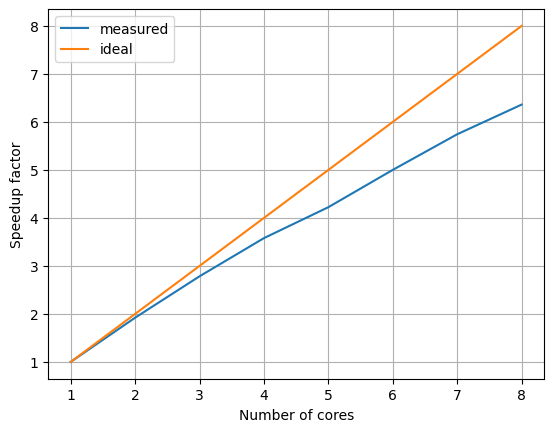

In [18]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.plot(np.arange(1,num_processes+1), 1/(times/times[0]), label='measured')
ax.plot(np.arange(1,num_processes+1), np.arange(1,num_processes+1), label='ideal')
ax.set_xlabel('Number of cores')
ax.set_ylabel('Speedup factor')
ax.legend()
ax.grid()

4. Ideal scaling represents a problem with no serial component at all, and scaling worsens as the serial fraction dominates. How does our strong scaling compare to the ideal? What does this tell us about the serial component of our prime search?

Our strong scaling follows the ideal speedup somewhat closely, but deviates by over 1 factor by the time we get to the use of 6 cores and above. This tells us that the serial component of the program is coming closer to dominating the runtime, but there is still some speedup that can be achieved if desired.

5. Amdahl's Law tells us that as some point, we should expect the amount of speedup to flatten out as we increase the number of processes. It's not beneficial to keep increasing the number of processes after this point. With the limited number of processes we've timed, do you see any evidence of this flattening? What does this tell you about trying more than 8 processes?

The flattening definitely appears as though it will be occurring at some point after 8 cores, so there could be some benefit to be found in the range of using 8-12 cores, but I would imagine it would flatten out significantly after that point.

---
## Weak Scaling

"Weak scaling" is an alternative to strong scaling where we let the total amount of work vary as we adjust the number of processes. Instead, for weak scaling measurements, we **fix the amount of work per process.** Weak scaling acknowledges our tendency to solve bigger and bigger computational problems as we have access to more and more resources. Weak scaling measurements tell us how well our code will handle moving to larger and larger problems.

We will again **vary the number of processes from 1 to 8,** but this time, **the search range will also change.**

---
### Exercises

1. Let's fix each process's "workload" at 200,000 numbers. That is, if we evenly distribute the total number of values that we are checking for prime numbers, each process should each check 200,000 of them. If we start our search at 100,000,000 and only use one process, the end point of the search range should be 100,200,000. What will this end value be as we increase the number of processes?

In [19]:
print('Using 200,000 numbers per process..')
num_processes = 8
for i in range(1,num_processes+1):
    print(f'... the end value with {i} processes will be {100000000+i*(200000)}')

Using 200,000 numbers per process..
... the end value with 1 processes will be 100200000
... the end value with 2 processes will be 100400000
... the end value with 3 processes will be 100600000
... the end value with 4 processes will be 100800000
... the end value with 5 processes will be 101000000
... the end value with 6 processes will be 101200000
... the end value with 7 processes will be 101400000
... the end value with 8 processes will be 101600000


2. Adjusting the end point of the search range accordingly, time how long the prime number search takes as you adjust the number of processes used.

In [31]:
start = int(100000000)
work_per_process = 200000
num_processes = 8

times = np.empty(num_processes)
for i in range(1,num_processes+1):
    start_time = time.perf_counter()
    primes = give_primes(start=start,end=start+i*work_per_process,num_processes=i)
    end_time = time.perf_counter()
    times[i-1] = end_time - start_time
    print(f"Time with {i} cores: {round(end_time - start_time,4)} seconds")

Time with 1 cores: 3.9184 seconds
Time with 2 cores: 4.0304 seconds
Time with 3 cores: 4.1209 seconds
Time with 4 cores: 4.1955 seconds
Time with 5 cores: 4.2806 seconds
Time with 6 cores: 4.3863 seconds
Time with 7 cores: 4.5993 seconds
Time with 8 cores: 4.7288 seconds


3. Use your timing measurements from above to plot the parallel efficiency as a function of the number of processes. Recall that efficiency is calculated the same way as the parallel speedup; the interpretation of this value depends on what kind of scaling we are analyzing. Perfect weak scaling will have an efficiency of 1.0 (100%) for all processes. Add this reference line to your plot, and set the bounds on the y-axis such that you can see zero. Remember to label your axes and include a legend.

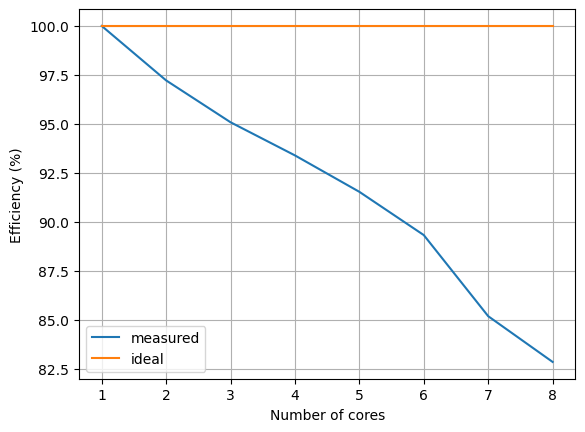

In [32]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.plot(np.arange(1,num_processes+1), 100*times[0]/times, label='measured')
ax.plot(np.arange(1,num_processes+1), 100*np.ones(num_processes), label='ideal')
ax.set_xlabel('Number of cores')
ax.set_ylabel('Efficiency (%)')
ax.legend()
ax.grid()

4. Repeat your timing measurements but change the amount of work done per process to both 100,000 values and 400,000 values (halving and doubling the amount of work respectively). Add these additional measurements to the weak scaling plot.

Time with 1 cores: 1.9629 seconds
Time with 2 cores: 1.9269 seconds
Time with 3 cores: 2.0126 seconds
Time with 4 cores: 2.0835 seconds
Time with 5 cores: 2.1737 seconds
Time with 6 cores: 2.2026 seconds
Time with 7 cores: 2.2341 seconds
Time with 8 cores: 2.5036 seconds
Time with 1 cores: 3.7088 seconds
Time with 2 cores: 3.803 seconds
Time with 3 cores: 3.9698 seconds
Time with 4 cores: 4.1147 seconds
Time with 5 cores: 4.2512 seconds
Time with 6 cores: 4.3711 seconds
Time with 7 cores: 4.4026 seconds
Time with 8 cores: 4.929 seconds
Time with 1 cores: 7.615 seconds
Time with 2 cores: 7.6155 seconds
Time with 3 cores: 7.8623 seconds
Time with 4 cores: 7.9602 seconds
Time with 5 cores: 8.5321 seconds
Time with 6 cores: 8.4695 seconds
Time with 7 cores: 8.4975 seconds
Time with 8 cores: 8.5718 seconds


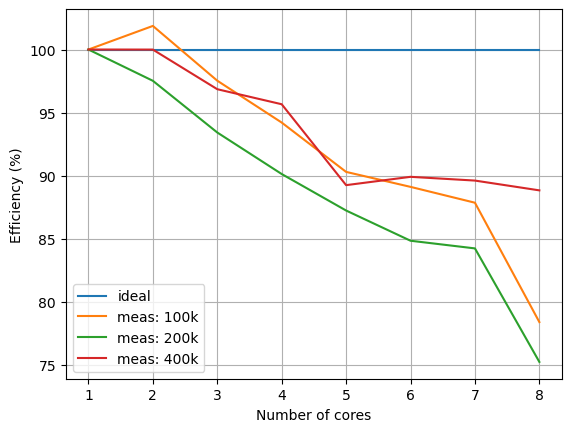

In [35]:
start = int(100000000)
work_per_process = [100000,200000,400000]
num_processes = 8

fig,ax = plt.subplots()
ax.plot(np.arange(1,num_processes+1), 100*np.ones(num_processes), label='ideal')
ax.set_xlabel('Number of cores')
ax.set_ylabel('Efficiency (%)')
ax.grid()

for w in work_per_process:
    times = np.empty(num_processes)
    for i in range(1,num_processes+1):
        start_time = time.perf_counter()
        primes = give_primes(start=start,end=start+i*w,num_processes=i)
        end_time = time.perf_counter()
        times[i-1] = end_time - start_time
        print(f"Time with {i} cores: {round(end_time - start_time,4)} seconds")
    ax.plot(np.arange(1,num_processes+1), 100*times[0]/times, label=f'meas: {int(w/1000)}k')
ax.legend()

5. Ideal weak scaling doesn't mean that the program's runtime stays the same as we increase the amount of work; rather, perfect weak scaling indicates there is no additional **overhead** when we increase the number of **processes**. Managing multiple processes always incurs some amount of overhead, and generally this overhead increases when we add more processes. Do your weak scaling measurements indicate the influence of increasing overhead? Is that overhead significantly affected by the amount of work per process?

The trendlines for each workload per process indicate a similar amount of efficiency decrease per additional process managed, but there is no significant additional efficiency increase or decrease noted between the lines (one should be decreasing faster than the others, but they all decrease at the same approximate rate ;although they may be vertically separated slightly, rate of change is not significantly affected). The value above 100% indicates that more is gained from parallelization than is lost to additional overhead.

## Takeaways

In the Load Balancing section, we saw that `chunksize`s near or below the default `chunksize` had the best performance. This was true even though the time it takes to determine whether or not a number is prime varies depending on the number. **In general, `Pool.map`'s default `chunksize` is a sensible value**, even if there might be a similar `chunksize` that is technically more optimal. Sometimes, though, it may need to be changed in order to improve performance.

For the Strong and Weak Scaling sections, the prime number search scales fairly similarly to the ideal case. This is because of its pleasantly parallel nature. Over the next few weeks will explore techniques that make our programs _not_ pleasantly parallel. These techniques are sometimes unavoidable, but our scaling will be negatively impacted.

## For Next Class

* We'll be using a utility called `partial` from the built-in `functools` library. Read [this tutorial](https://www.pythontutorial.net/python-basics/python-partial-functions/) on `partial`.